# Contents

> - [Introduction](#Introduction)
> - [Data Collection and Analysis](#Data-Collection-and-Analysis)
     - [Data Sources](#Data-Sources)
     - [Data Cleaning and Structuring](#Data-Cleaning-and-Structuring)
     - [Data Analysis](#Data-Analysis)
>

# Introduction

India is the second-most populous country, the seventh-largest country by area and the most populous democracy in the world. The trending population is around 1.35 billions. India has 29 states and 7 union territories with around 300+ popular citities.  The goal of the analysis is to analyse the popular venues with the state capitals and popular cities in India along with the population data of each city/capitals to understand their influence over trending venues and find out the best possible business category to start in India.

The analysis answers the following for an entrepreneur who wants to start a business in India, 
        1. What are the trending businesses across Indian state capitals?
        2. What are the trending businesses across Indian cities?
        3. Does population of a state capital or city influence the business trends?
        4. Should I start a buisness in a state capital or any cities in India?
        5. Which category of business should I consider?
        
[<div style="text-align: right"> Back to Contents </div>](#Contents)
    

# Data Collection and Analysis

Based on the questions listed in Business Problem, the data we will be looking for our analysis are,

    1. Indian state capital list
    2. Indian cities list
    3. Population data of Indian state capitals and cities
    4. Location data of Indian state capitals and cities
    5. Trending venue data of Indian state capitals and cities
    
### Data Sources
    
#### Indian State Capitals
Capital cities data are required for anlayzing popular venues across state capitals. We will get this data from wikipedia [List of state and union territory capitals in India](https://en.wikipedia.org/wiki/List_of_state_and_union_territory_capitals_in_India). We will only take State and Administrative Capital column from this data set.
#### Indian Cities and Population data
There are around 300+ popular cities in India which we can get from wikipedia [List of cities in India by population](https://en.wikipedia.org/wiki/List_of_cities_in_India_by_population). Along with the cities list, we also get population data from this data set. 

_Note: This analysis is based on 2011 census population data. Though this might have increased approximately by 17% to 20% over the decade, we go with the currently available data set for this analysis. However, the whole analysis can be reused when the new dataset is available._

#### Location Data
To get the venue details of cities and capitals, we will require their latitude and logitude data. We will use python's geopy library to get these details. To save time, the location details are also captured on the first run to a csv file which you can download from github repository.

#### Venue Data
To get the venue details of cities and capitals, we will use [foursquare.com](https://developer.foursquare.com/) apis through developer account.

### Data Cleaning and Structuring

There are two primary data sources we use for collecting Indian state capitals and cities details. Both of them are from wikipedia pages, but with different column sets. The state capitals table has no population data and both of the data tables doesn't have geo location data. Though the wikipedia data sets have a lot of details in different columns, we are only interested in City/Capital names, State names (required for data frame joins) and population data. We will dropout rest of the columns during data cleaning process. Also, we will have to remove subscript, superscript notations used in wiki pages for reference links. Python geopy library will be used to collect geo location of each city and the final dataset will have data like the below sample,

<table>
    <tr><th>State</th>	<th>City</th>	<th>Latitude</th>	<th>Longitude</th>	<th>Population</th></tr>
    <tr><td>Andhra Pradesh</td><td>Amaravati</td><td>16.516910</td><td>80.500259</td><td>103000</td></tr>
    <tr><td>Bihar</td><td>Patna</td><td>25.609324</td><td>85.123525</td><td>1684222</td></tr>
    <tr><td>Chandigarh</td><td>Chandigarh</td><td>30.719402</td><td>76.764655</td><td>1028667</td></tr>
    <tr><td>Delhi</td><td>New Delhi</td><td>28.614179</td><td>77.202266</td><td>249998</td></tr>
    <tr><td>Gujarat</td><td>Gandhinagar</td><td>23.223288</td><td>72.649227</td><td>206167</td></tr>
</table>

Since state capitals data and cities data are from different wikipedia pages, there are high chances that we will be missing or having mismatched capital city names (for population data collection). We will use dataframe merge method to compare both the dataframes to find out missing capital cities and manually add missing details through a csv import. With the population category added to our dataset, we will use foursquare api to collect venue details of each Indian state capitals and cities and add them to our dataset for analysis. With the foursquare data added, our dataset will look like the below sample,

<table>
    <tr><th>State</th><th>Capital</th><th>Latitude</th><th>Longitude</th><th>Population</th><th>Category</th></tr>
<tr><td>Maharashtra</td><td>Mumbai</td><td>18.938771</td><td>72.835335</td><td>12442373</td><td>High</td></tr>
<tr><td>Karnataka</td><td>Bangalore</td><td>12.979120</td><td>77.591300</td><td>8436675</td><td>High</td></tr>
<tr><td>Telangana</td><td>Hyderabad</td><td>17.388786</td><td>78.461065</td><td>6809970</td><td>High</td></tr>
<tr><td>Tamil Nadu</td><td>Chennai</td><td>13.080172</td><td>80.283833</td><td>4681087</td><td>High</td></tr>
<tr><td>West Bengal</td><td>Kolkata</td><td>22.545412</td><td>88.356775</td><td>4486679</td><td>High</td></tr>
</table>

### Data Analysis

We will start with population analysis of Indian cities and state capitals by categorizing the population into High, Medium and Low populated areas. This will give us an insight of population across Indian state capitals and cities. Folium maps will come handy to plot the population stats on India map for visual analysis.

With the venue data collected using Foursquare.com apis that are merged with both the datasets of Indian state capitals and cities, later we will use KMeans clustering technique to cluster popular venues against each data points (locations) and find out differences and similarities of venues against population of the location.

Finally, we will comapre both the datasets of Indian state capitals and cities to identify which venue is more popular on both the datasets and are there any differences, similarities of venue categories between state capital cities and regular cities.


[<div style="text-align: right"> Back to Contents </div>](#Contents)

In [442]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium
import json, requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import geocoder # import geocoder
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
%matplotlib inline

# function that formats data frame from wiki tables
def formatDF(data):
    data.columns=data.iloc[0]
    data= data.reindex(data.index.drop(0)).reset_index(drop=True)
    data.columns.name = None
    return data

# function that returns latitude, logitude for the given address
def getLatLong(address):
    success=False
    counter=5 #5 attempts
    while((not success) and counter>0):
        counter-=1
        try:
            geolocator = Nominatim(user_agent="loc_explorer")
            location = geolocator.geocode(address)
            success=True
            return {'latitude': location.latitude, 'longitude': location.longitude}
        except:
            success=False
    if(not success):
        return {'latitude': None, 'longitude': None}


In [443]:
df_capitals=pd.read_html('https://en.wikipedia.org/wiki/List_of_state_and_union_territory_capitals_in_India')
df=formatDF(df_capitals[1])
df.drop(['Legislative capital','Judicial capital','Year of establishment','Former capital','No.'],inplace=True, axis=1)
df.rename(columns={'State orunion territory':'State','Administrative capital':'Capital'},inplace=True)
df['State']=df['State'].apply(lambda x: x.split('(')[0].split('[')[0].strip())
df['Capital']=df['Capital'].apply(lambda x: x.split('(')[0].split('[')[0].strip())
df.head()

,State,Capital
0,Andaman and Nicobar Islands,Port Blair
1,Andhra Pradesh,Amaravati
2,Arunachal Pradesh,Itanagar
3,Assam,Dispur
4,Bihar,Patna


In [444]:
#loc=pd.DataFrame(columns=['Capital','State','Latitude','Longitude'])
#for index, row in df.iterrows():
#    print('Processing {}, {} ({})'.format(row['State'],row['Capital'],index))
#    ll=getLatLong('{}, {}, India'.format(row['Capital'],row['State']))
#    print(ll)
#    loc=loc.append(pd.Series([row['Capital'],row['State'],ll['latitude'],ll['longitude']], index=loc.columns),ignore_index=True)
#loc.to_csv('CapitalLocations1.csv', index=False)
loc=pd.read_csv('CapitalLocations.csv')
df2=pd.merge(df,loc,on=['Capital','State'])
df2.rename(columns={'Capital':'City'},inplace=True)
df2.head()

,State,City,Latitude,Longitude
0,Andaman and Nicobar Islands,Port Blair,11.664535,92.739045
1,Andhra Pradesh,Amaravati,16.516910,80.500259
2,Arunachal Pradesh,Itanagar,27.097966,93.623729
3,Assam,Dispur,26.151308,91.793381
4,Bihar,Patna,25.609324,85.123525


In [445]:
df_cities=pd.read_html('https://en.wikipedia.org/wiki/List_of_cities_in_India_by_population')
dfp=formatDF(df_cities[0])
dfp.drop(['Rank','Population(2001)'],inplace=True, axis=1)
dfp.rename(columns={'Population(2011)[3]':'Population','State or union territory':'State'},inplace=True)
dfp['City']=dfp['City'].apply(lambda x: x.split('(')[0].split('[')[0].strip())
dfp['State']=dfp['State'].apply(lambda x: x.split('(')[0].split('[')[0].strip())
dfp=dfp.astype({'Population':'int'})
dfp.sort_values(by=['Population'],inplace=True,ascending=False)
print('Number of cities:',len(dfp['City']))
dfp.head()

Number of cities: 301


,City,Population,State
0,Mumbai,12442373,Maharashtra
1,Delhi,11007835,Delhi
2,Bangalore,8436675,Karnataka
3,Hyderabad,6809970,Telangana
4,Ahmedabad,5570585,Gujarat


In [446]:
dff=pd.merge(df2,dfp,on=['City','State'])
dff.head()

,State,City,Latitude,Longitude,Population
0,Andhra Pradesh,Amaravati,16.516910,80.500259,103000
1,Bihar,Patna,25.609324,85.123525,1684222
2,Chandigarh,Chandigarh,30.719402,76.764655,1028667
3,Delhi,New Delhi,28.614179,77.202266,249998
4,Gujarat,Gandhinagar,23.223288,72.649227,206167


In [447]:
#tmp = df2.merge(dff, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']
#tmp.to_csv('MissingCities.csv')
tmp=pd.read_csv('MissingCities.csv')
dfc=pd.concat([dff,tmp])
dfc.sort_values(by=['Population'],inplace=True,ascending=False)
dfc=dfc.reset_index(drop=True)
dfc.rename(columns={'City':'Capital'},inplace=True)
print('Final processed cities: ',len(dfc['Capital']))
dfc.head()

Final processed cities:  36


,State,Capital,Latitude,Longitude,Population
0,Maharashtra,Mumbai,18.938771,72.835335,12442373
1,Karnataka,Bangalore,12.979120,77.591300,8436675
2,Telangana,Hyderabad,17.388786,78.461065,6809970
3,Tamil Nadu,Chennai,13.080172,80.283833,4681087
4,West Bengal,Kolkata,22.545412,88.356775,4486679


In [448]:
# Note:Chandigarh is a special city acts as capital of two neighbor states but is a union territory by own
print("Duplicates:\n",dfc.duplicated(subset=['Capital'],keep=False).value_counts())

# We only look at capital city here, lets drop the duplicate rows (2 States might go off the list)
dfc.drop_duplicates(subset ="Capital", keep = 'first', inplace = True)

dfc.reset_index(drop=True,inplace=True)

print("Dropped duplicates:\n",dfc.duplicated(subset=['Capital'],keep=False).value_counts())
print('Cities: ',len(dfc['Capital']))
dfc.head()

Duplicates:
 False    33
True      3
dtype: int64
Dropped duplicates:
 False    34
dtype: int64
Cities:  34


,State,Capital,Latitude,Longitude,Population
0,Maharashtra,Mumbai,18.938771,72.835335,12442373
1,Karnataka,Bangalore,12.979120,77.591300,8436675
2,Telangana,Hyderabad,17.388786,78.461065,6809970
3,Tamil Nadu,Chennai,13.080172,80.283833,4681087
4,West Bengal,Kolkata,22.545412,88.356775,4486679


In [449]:
low=round(dfc['Population'].quantile(q=0.33))
medium=round(dfc['Population'].quantile(q=0.66))
conditions=[
    (dfc['Population'] <= low),
    (dfc['Population'] > low) & (dfc['Population'] <= medium), 
    (dfc['Population'] > medium)
]
choices=['Low','Medium','High']
dfc['Category']=np.select(condlist=conditions,choicelist=choices)
dfc.head()


,State,Capital,Latitude,Longitude,Population,Category
0,Maharashtra,Mumbai,18.938771,72.835335,12442373,High
1,Karnataka,Bangalore,12.979120,77.591300,8436675,High
2,Telangana,Hyderabad,17.388786,78.461065,6809970,High
3,Tamil Nadu,Chennai,13.080172,80.283833,4681087,High
4,West Bengal,Kolkata,22.545412,88.356775,4486679,High


In [450]:
# get latitude and longitude of India
ll=getLatLong('India')

# create map of India with cities marked using latitude and longitude values of the cities
map_india = folium.Map(location=[ll['latitude'],ll['longitude']], zoom_start=4)

# add markers to map
for lat, lng, Population, City, Category in zip(dfc['Latitude'], dfc['Longitude'], dfc['Population'], dfc['Capital'], dfc['Category']):
    label = '{}, Population: {}'.format(City, Population)
    label = folium.Popup(label, parse_html=True)
    c='green'
    fc='#55aa77'
    if(Category=='High'):
        c='red'
        fc='#ff7755'
    elif(Category=='Medium'):
        c='yellow'
        fc='#aa9955'
    folium.CircleMarker([lat, lng], radius=5, popup=label, color=c, fill=True, fill_color=fc, fill_opacity=0.7,
        parse_html=False).add_to(map_india)  
    
map_india

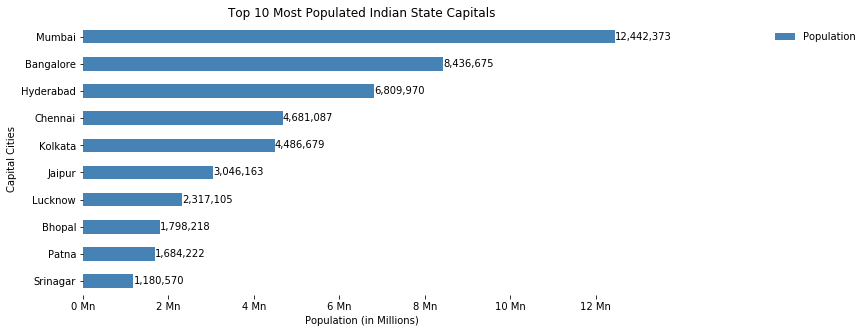

In [451]:
dfc_plt=dfc[['Capital','Population']].set_index(
    "Capital",
    drop=True).sort_values(
    by=['Population'],
    ascending=True)['Population'].tail(10)
ax=dfc_plt.plot(kind='barh', figsize=(10,5), color='steelblue')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda v,t:'{} Mn'.format(int(np.round(v/1000000)))))

plt.title('Top 10 Most Populated Indian State Capitals')
plt.ylabel('Capital Cities')
plt.xlabel('Population (in Millions)')
for index, value in enumerate(dfc_plt): 
    label = format(int(value), ',') # format int with commas
    # place text at the end of bar (subtracting 47000 from x, and 0.1 from y to make it fit within the bar)
    plt.annotate(label, xy=(value, index - 0.10), color='black')
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1), frameon=False)
for spine in ax.spines:
    ax.spines[spine].set_visible(False)
plt.show()

## Foursquare

In [452]:

def getFoursquareJson(lat,lng,_limit=100,_option='explore'):
    url = 'https://api.foursquare.com/v2/venues/{}'.format(_option)
    params = dict(
        client_id='3SPEOINY0KTWJE1TB3IMXQ1CLKNR0TTTJJTTU1B1IBSZW1JP',
        client_secret='VJ2Z2P1YAZJ43LU1TYT4JT3FYD1CSIKH2MRNXXJ3E3FLS1JG',
        v='20180605',
        ll='{},{}'.format(lat,lng),
        limit=_limit
        )
    return requests.get(url=url, params=params).json()

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    

In [453]:
index=1
address = '{}, {}, India'.format(dfc.loc[index, 'Capital'], dfc.loc[index, 'State'])
results = getFoursquareJson(dfc.loc[index,'Latitude'],dfc.loc[index,'Longitude'],200)
results

{'meta': {'code': 200, 'requestId': '5edfaccbc546f3001b4d7863'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'suggestedRadius': 1578,
  'headerLocation': 'Bangalore',
  'headerFullLocation': 'Bangalore',
  'headerLocationGranularity': 'city',
  'totalResults': 98,
  'suggestedBounds': {'ne': {'lat': 12.994386172606708,
    'lng': 77.60638771562276},
   'sw': {'lat': 12.964746619862806, 'lng': 77.57574665827659}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bbc4513e45295217db855a4',
       'name': 'Cubbon Park',
       'location': {'address': 'M G Road',
        'lat': 12.977042175203783,
        'lng': 77.59527683258057,
        'labeledLatLngs': [{'label': 'display',
          'lat': 12.977

In [454]:
venues = json_normalize(results['response']['groups'][0]['items']) 
columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
venues =venues.loc[:, columns]
venues['venue.categories'] = venues.apply(get_category_type, axis=1)
venues.columns = [col.split(".")[-1].title() for col in venues.columns]

print('Total venues returned for {} ({}):{} '.format(dfc.loc[index, 'Capital'],dfc.loc[index, 'State'], venues.shape[0]))
venues.head()

Total venues returned for Bangalore (Karnataka):98 


,Name,Categories,Lat,Lng
0,Cubbon Park,Park,12.977042,77.595277
1,JW Marriott Hotel Bengaluru,Hotel,12.972362,77.595051
2,Taj West End,Hotel,12.984572,77.584893
3,M. Chinnaswamy Stadium,Cricket Ground,12.978144,77.599223
4,Infinitea,Tea Room,12.987157,77.594835


In [456]:
venues_list=[]
for i in range(dfc.shape[0]):
    address = '{}, {}, India'.format(dfc.loc[i, 'Capital'], dfc.loc[i, 'State'])
    print(address)
    venues = getFoursquareJsonEx(dfc.loc[i,'Latitude'],dfc.loc[i,'Longitude'],200)
    columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues =venues.loc[:, columns]
    venues['venue.categories'] = venues.apply(get_category_type, axis=1)
    venues.columns = [col.split(".")[-1].title() for col in venues.columns]
    venues_list.append([(
            dfc.loc[i,'Capital'], 
            dfc.loc[i,'Latitude'],dfc.loc[i,'Longitude'], 
            venues.loc[j,'Name'], 
            venues.loc[j,'Lat'], 
            venues.loc[j,'Lng'],  
            venues.loc[j,'Categories']) for j in range(venues.shape[0])])
nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nearby_venues.columns = ['Capital', 
              'Capital Latitude', 
              'Capital Longitude', 
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category']
nearby_venues.head()    

Mumbai, Maharashtra, India
Bangalore, Karnataka, India
Hyderabad, Telangana, India
Chennai, Tamil Nadu, India
Kolkata, West Bengal, India
Jaipur, Rajasthan, India
Lucknow, Uttar Pradesh, India
Bhopal, Madhya Pradesh, India
Patna, Bihar, India
Srinagar, Jammu and Kashmir, India
Ranchi, Jharkhand, India
Chandigarh, Haryana, India
Naya Raipur, Chhattisgarh, India
Dispur, Assam, India
Bhubaneswar, Odisha, India
Dehradun, Uttarakhand, India
Thiruvananthapuram, Kerala, India
Agartala, Tripura, India
Aizawl, Mizoram, India
Leh, Ladakh, India
Imphal, Manipur, India
New Delhi, Delhi, India
Pondicherry, Puducherry, India
Gandhinagar, Gujarat, India
Daman, Dadra and Nagar Haveli and Daman and Diu, India
Shimla, Himachal Pradesh, India
Shillong, Meghalaya, India
Kohima, Nagaland, India
Amaravati, Andhra Pradesh, India
Gangtok, Sikkim, India
Port Blair, Andaman and Nicobar Islands, India
Itanagar, Arunachal Pradesh, India
Panaji, Goa, India
Kavaratti, Lakshadweep, India


,Capital,Capital Latitude,Capital Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Mumbai,18.938771,72.835335,Royal China,18.938715,72.832933,Chinese Restaurant
1,Mumbai,18.938771,72.835335,Town House Cafe,18.938550,72.833464,Bar
2,Mumbai,18.938771,72.835335,Sher-E-Punjab,18.937944,72.837853,Indian Restaurant
3,Mumbai,18.938771,72.835335,Britannia & Co.,18.934683,72.840183,Parsi Restaurant
4,Mumbai,18.938771,72.835335,Cafe Excelsior,18.937701,72.833566,Café


## Analyzing Venues of Capital Cities

In [459]:
nearby_venues.to_csv('capital_venues.csv')
print('There are total {} venues in all Indian state capitals and there are {} uniques venue categories.'.format(
    nearby_venues.shape[0],len(nearby_venues['Venue Category'].unique())))

There are total 1457 venues in all Indian state capitals and there are 196 uniques venue categories.


In [460]:
venue_dummies = pd.get_dummies(nearby_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venue_dummies['Capital'] = nearby_venues['Capital'] 

# move neighborhood column to the first column
columns = [venue_dummies.columns[-1]] + list(venue_dummies.columns[:-1])
venue_dummies = venue_dummies[columns]

venue_dummies.head()

,Capital,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,Airport Terminal,American Restaurant,Arcade,Art Gallery,...,Track Stadium,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Waterfront,Wine Bar,Zoo
0,Mumbai,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Mumbai,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Mumbai,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Mumbai,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Mumbai,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [461]:
venues_grouped = venue_dummies.groupby('Capital').mean().reset_index()
print(venues_grouped.shape)
venues_grouped

(34, 197)


,Capital,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,Airport Terminal,American Restaurant,Arcade,Art Gallery,...,Track Stadium,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Waterfront,Wine Bar,Zoo
0,Agartala,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.333333,0.00,0.000000,0.000000,0.000000,0.000,0.000000,0.00000
1,Aizawl,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000,0.000000,0.00000
2,Amaravati,0.250000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.125,0.000000,0.00000
3,Bangalore,0.000000,0.00000,0.010204,0.000000,0.00,0.000000,0.010204,0.010204,0.00,...,0.000000,0.00,0.000000,0.00,0.010204,0.000000,0.010204,0.000,0.010204,0.00000
4,Bhopal,0.000000,0.00000,0.000000,0.023810,0.00,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.023810,0.00,0.000000,0.000000,0.000000,0.000,0.000000,0.00000
5,Bhubaneswar,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000,0.000000,0.00000
6,Chandigarh,0.333333,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.111111,0.00,0.000000,0.000000,0.000000,0.000,0.000000,0.00000
7,Chennai,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.023810,0.00,0.023810,0.011905,0.000000,0.000,0.000000,0.00000
8,Daman,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.038462,0.00,...,0.000000,0.00,0.076923,0.00,0.000000,0.000000,0.000000,0.000,0.000000,0.00000
9,Dehradun,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.027778,0.00,0.000000,0.000000,0.000000,0.000,0.000000,0.00000


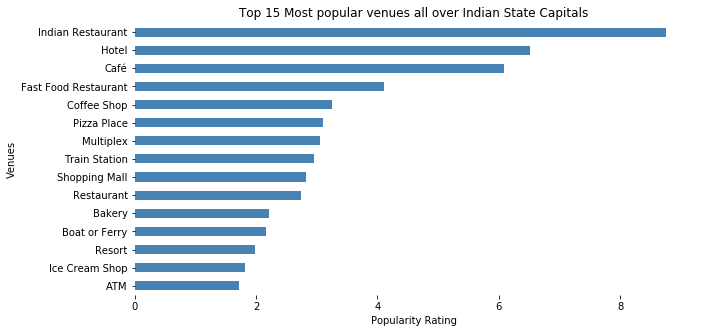

In [462]:
popular=venues_grouped.describe().loc['mean'].sort_values().tail(15)

ax=popular.plot(kind='barh', figsize=(10,5), color='steelblue')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda v,t: int(np.round(v*100))))

plt.title('Top 15 Most popular venues all over Indian State Capitals')
plt.ylabel('Venues')
plt.xlabel('Popularity Rating')
for spine in ax.spines:
    ax.spines[spine].set_visible(False)
plt.show()

In [463]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [464]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Capital']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
top_venues_sorted = pd.DataFrame(columns=columns)
top_venues_sorted['Capital'] = venues_grouped['Capital']

for ind in np.arange(venues_grouped.shape[0]):
    top_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

top_venues_sorted.head()

,Capital,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agartala,Train Station,Coffee Shop,Men's Store,Multiplex,Salad Place,Zoo,Farmers Market,Food Court,Food & Drink Shop,Food
1,Aizawl,Restaurant,Hotel,Park,Shopping Mall,Zoo,Electronics Store,Food & Drink Shop,Food,Flea Market,Fish & Chips Shop
2,Amaravati,ATM,Pharmacy,Indian Restaurant,Harbor / Marina,Waterfront,Accessories Store,Food Truck,Food Court,Food & Drink Shop,Food
3,Bangalore,Indian Restaurant,Hotel,Lounge,Ice Cream Shop,Japanese Restaurant,Italian Restaurant,Breakfast Spot,Park,Bookstore,Restaurant
4,Bhopal,Pizza Place,Indian Restaurant,Coffee Shop,Bakery,Asian Restaurant,Diner,Hotel,Fast Food Restaurant,Café,Department Store


In [465]:
capitals_grouped_clustering = venues_grouped.drop('Capital', 1)

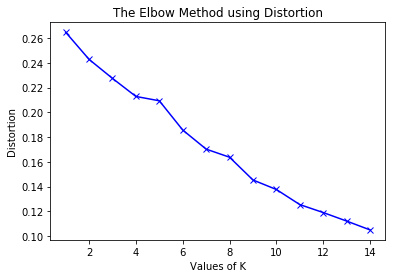

In [470]:
from sklearn import metrics 
from scipy.spatial.distance import cdist 
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,15)
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(capitals_grouped_clustering) 
      
    distortions.append(sum(np.min(cdist(capitals_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / capitals_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(capitals_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / capitals_grouped_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

In [471]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(capitals_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 3, 0, 0, 0, 0, 0, 0, 0, 0])

In [472]:
try:
    top_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
except:
    pass
capitals_merged = dfc

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
capitals_merged = capitals_merged.join(top_venues_sorted.set_index('Capital'), on='Capital')

capitals_merged[capitals_merged['Cluster Labels']!=0]

,State,Capital,Latitude,Longitude,Population,Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Mizoram,Aizawl,23.741409,92.720930,291822,Medium,3,Restaurant,Hotel,Park,Shopping Mall,Zoo,Electronics Store,Food & Drink Shop,Food,Flea Market,Fish & Chips Shop
31,Arunachal Pradesh,Itanagar,27.097966,93.623729,59490,Low,2,Ice Cream Shop,Mobile Phone Shop,Train Station,Fried Chicken Joint,Zoo,Farmers Market,Food Truck,Food Court,Food & Drink Shop,Food
33,Lakshadweep,Kavaratti,10.559050,72.636569,11473,Low,1,Boat or Ferry,Bank,Zoo,Gaming Cafe,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Food


In [473]:
# create map
map_clusters = folium.Map(location=[ll['latitude'], ll['longitude']], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []

for lat, lon, poi, cluster, Category in zip(capitals_merged['Latitude'], capitals_merged['Longitude'], capitals_merged['Capital'], capitals_merged['Cluster Labels'], capitals_merged['Category']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    c='green'
    fc='#55aa77'
    if(Category=='High'):
        c='red'
        fc='#ff7755'
    elif(Category=='Medium'):
        c='yellow'
        fc='#aa9955'
    folium.CircleMarker([lat, lon], radius=7, popup=label, color=c, fill=True, fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

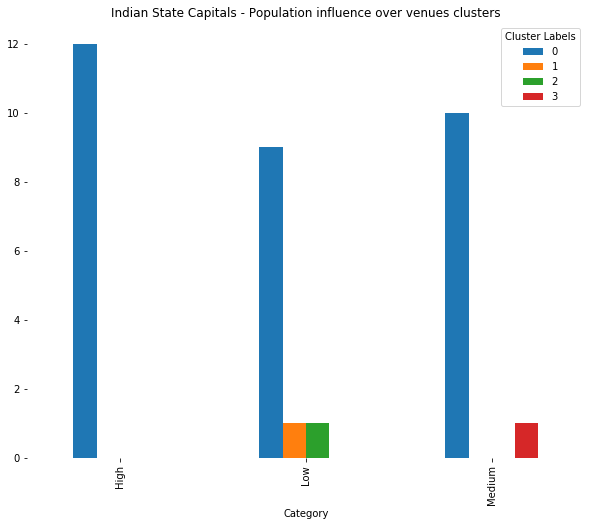

In [525]:
def plotCapitalGraph():
    dfg=capitals_merged.groupby(['Category','Cluster Labels'])['Cluster Labels']
    ax=dfg.count().unstack('Cluster Labels').plot(
        kind='bar',
        figsize=(10,8))
    #ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,t: 'Cluster {}'.format(v)))
    plt.title('Indian State Capitals - Population influence over venues clusters')
    #plt.xlabel('Venues')
    #plt.ylabel('Clusters')
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
    plt.show()

plotCapitalGraph()

In [507]:
capitals_merged.loc[capitals_merged['Cluster Labels'] == 0, capitals_merged.columns[[1] + list(range(7, capitals_merged.shape[1]))]]

,Capital,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Mumbai,Indian Restaurant,Café,Cricket Ground,Seafood Restaurant,Bakery,Fast Food Restaurant,Ice Cream Shop,Chinese Restaurant,Coffee Shop,Hotel
1,Bangalore,Indian Restaurant,Hotel,Lounge,Ice Cream Shop,Japanese Restaurant,Italian Restaurant,Breakfast Spot,Park,Bookstore,Restaurant
2,Hyderabad,Indian Restaurant,Multiplex,Fast Food Restaurant,Hotel,Bakery,Café,Ice Cream Shop,Chinese Restaurant,South Indian Restaurant,Juice Bar
3,Chennai,Indian Restaurant,Hotel,Pizza Place,Multiplex,Café,Train Station,Farmers Market,Bookstore,Department Store,Clothing Store
4,Kolkata,Café,Indian Restaurant,Nightclub,Hotel,Bakery,Mughlai Restaurant,Dhaba,Chinese Restaurant,Restaurant,Indian Sweet Shop
5,Jaipur,Hotel,Indian Restaurant,Café,Historic Site,Bakery,Italian Restaurant,Restaurant,Coffee Shop,Tea Room,Ice Cream Shop
6,Lucknow,Indian Restaurant,Fast Food Restaurant,Hotel,Café,Pizza Place,Shopping Mall,Bakery,Multiplex,Department Store,Ice Cream Shop
7,Bhopal,Pizza Place,Indian Restaurant,Coffee Shop,Bakery,Asian Restaurant,Diner,Hotel,Fast Food Restaurant,Café,Department Store
8,Patna,Pizza Place,Café,Indian Restaurant,Hotel,Park,Fast Food Restaurant,Juice Bar,Shopping Mall,Multiplex,Business Service
9,Srinagar,Garden,Café,Hotel,Shopping Mall,Indian Restaurant,Bakery,North Indian Restaurant,Coffee Shop,City,Chinese Restaurant


In [504]:
capitals_merged.loc[capitals_merged['Cluster Labels'] == 1, capitals_merged.columns[[1] + list(range(7, capitals_merged.shape[1]))]]

,Capital,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Kavaratti,Boat or Ferry,Bank,Zoo,Gaming Cafe,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Food


In [505]:
capitals_merged.loc[capitals_merged['Cluster Labels'] == 2, capitals_merged.columns[[1] + list(range(7, capitals_merged.shape[1]))]]

,Capital,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,Itanagar,Ice Cream Shop,Mobile Phone Shop,Train Station,Fried Chicken Joint,Zoo,Farmers Market,Food Truck,Food Court,Food & Drink Shop,Food


In [506]:
capitals_merged.loc[capitals_merged['Cluster Labels'] == 3, capitals_merged.columns[[1] + list(range(7, capitals_merged.shape[1]))]]

,Capital,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Aizawl,Restaurant,Hotel,Park,Shopping Mall,Zoo,Electronics Store,Food & Drink Shop,Food,Flea Market,Fish & Chips Shop


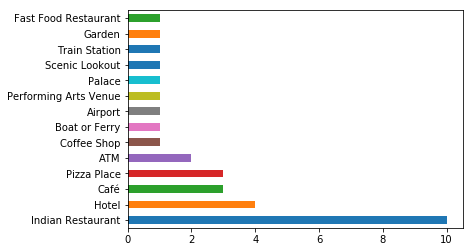

In [478]:
capitals_merged.loc[capitals_merged['Cluster Labels'] == 0, capitals_merged.columns[7]].value_counts().plot(kind='barh')

In [508]:
#loc=pd.DataFrame(columns=['City','State','Latitude','Longitude'])
#for index, row in dfp.iterrows():
#    print('Processing {}, {} ({})'.format(row['State'],row['Capital'],index))
#    ll=getLatLong('{}, {}, India'.format(row['Capital'],row['State']))
#    print(ll)
#    loc=loc.append(pd.Series([row['Capital'],row['State'],ll['latitude'],ll['longitude']], index=loc.columns),ignore_index=True)
#loc.to_csv('CityLocations.csv', index=False)
loc=pd.read_csv('CityLocations.csv')
dfct=pd.merge(dfp,loc,on=['City','State'])
dfct = dfct.drop(dfct[dfct['City'].isin(dfc['Capital'])].index).reset_index(drop=True)
dfct.sort_values(by=['Population'],inplace=True,ascending=False)
dfct.drop(dfct.loc[dfct['City']=='Delhi'].index,axis=0,inplace=True)
dfct.head()

,City,Population,State,Latitude,Longitude
1,Ahmedabad,5570585,Gujarat,23.021624,72.579707
2,Surat,4467797,Gujarat,21.186461,72.808128
3,Pune,3124458,Maharashtra,18.521428,73.854454
4,Visakhapatnam,2982904,Andhra Pradesh,17.723128,83.301284
5,Nagpur,2405665,Maharashtra,21.149813,79.082056


In [480]:
low=round(dfct['Population'].quantile(q=0.33))
medium=round(dfct['Population'].quantile(q=0.66))
conditions=[
    (dfct['Population'] <= low),
    (dfct['Population'] > low) & (dfct['Population'] <= medium), 
    (dfct['Population'] > medium)
]
choices=['Low','Medium','High']
dfct['Category']=np.select(condlist=conditions,choicelist=choices)
dfct.reset_index(drop=True,inplace=True)
dfct.head()


,City,Population,State,Latitude,Longitude,Category
0,Ahmedabad,5570585,Gujarat,23.021624,72.579707,High
1,Surat,4467797,Gujarat,21.186461,72.808128,High
2,Pune,3124458,Maharashtra,18.521428,73.854454,High
3,Visakhapatnam,2982904,Andhra Pradesh,17.723128,83.301284,High
4,Nagpur,2405665,Maharashtra,21.149813,79.082056,High


In [481]:
# get latitude and longitude of India
ll=getLatLong('India')

# create map of India with cities marked using latitude and longitude values of the cities
map_india = folium.Map(location=[ll['latitude'],ll['longitude']], zoom_start=4)

# add markers to map
for lat, lng, Population, City, Category in zip(dfct['Latitude'], dfct['Longitude'], dfct['Population'], dfct['City'], dfct['Category']):
    label = '{}, Population: {}'.format(City, Population)
    label = folium.Popup(label, parse_html=True)
    c='green'
    fc='#55aa77'
    if(Category=='High'):
        c='red'
        fc='#ff7755'
    elif(Category=='Medium'):
        c='yellow'
        fc='#aa9955'
    folium.CircleMarker([lat, lng], radius=5, popup=label, color=c, fill=True, fill_color=fc, fill_opacity=0.7,
        parse_html=False).add_to(map_india)  
    
map_india

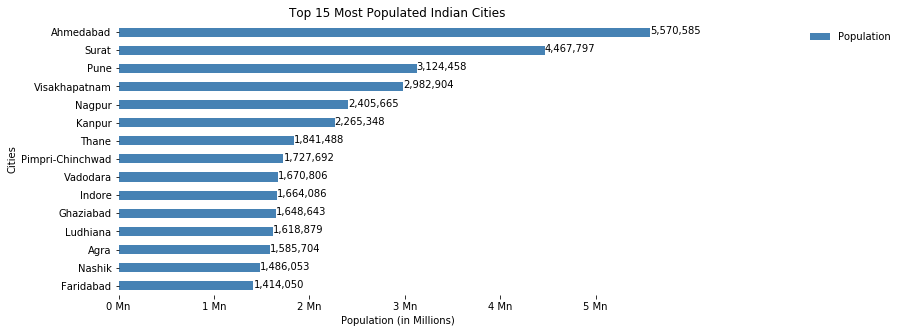

In [237]:
dfc_plt=dfct[['City','Population']].set_index(
    "City",
    drop=True).sort_values(
    by=['Population'],
    ascending=True)['Population'].tail(15)
ax=dfc_plt.plot(kind='barh', figsize=(10,5), color='steelblue')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda v,t:'{} Mn'.format(int(np.round(v/1000000)))))

plt.title('Top 15 Most Populated Indian Cities')
plt.ylabel('Cities')
plt.xlabel('Population (in Millions)')
for index, value in enumerate(dfc_plt): 
    label = format(int(value), ',') # format int with commas
    # place text at the end of bar (subtracting 47000 from x, and 0.1 from y to make it fit within the bar)
    plt.annotate(label, xy=(value, index - 0.10), color='black')
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1), frameon=False)
for spine in ax.spines:
    ax.spines[spine].set_visible(False)
plt.show()

In [482]:
import sys
# function that call foursquare api and return json venue list
def getFoursquareJsonEx(lat,lng,_limit=100,_option='explore'):
    url = 'https://api.foursquare.com/v2/venues/{}'.format(_option)
    params = dict(
        client_id='3SPEOINY0KTWJE1TB3IMXQ1CLKNR0TTTJJTTU1B1IBSZW1JP',
        client_secret='VJ2Z2P1YAZJ43LU1TYT4JT3FYD1CSIKH2MRNXXJ3E3FLS1JG',
        v='20180605',
        ll='{},{}'.format(lat,lng),
        limit=_limit
        )
    success=False
    counter=5
    venues=None
    while((not success) and counter>0):
        counter-=1
        try:
            results=requests.get(url=url, params=params).json()
            venues = json_normalize(results['response']['groups'][0]['items']) 
            success=True
        except:
            print(sys.exc_info()[0])
            success=False
    return venues

In [ ]:
venues_list=[]
for i in range(dfct.shape[0]):
    address = '{}, {}, India'.format(dfct.loc[i, 'City'], dfct.loc[i, 'State'])
    print(address)
    venues = getFoursquareJsonEx(dfct.loc[i,'Latitude'],dfct.loc[i,'Longitude'],200)
    columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    try:
        venues =venues.loc[:, columns]
    except:
        print(venues)
        print(sys.exc_info()[0])
        break;
    venues['venue.categories'] = venues.apply(get_category_type, axis=1)
    venues.columns = [col.split(".")[-1].title() for col in venues.columns]
    venues_list.append([(
            dfct.loc[i,'City'], 
            dfct.loc[i,'Latitude'],dfct.loc[i,'Longitude'], 
            venues.loc[j,'Name'], 
            venues.loc[j,'Lat'], 
            venues.loc[j,'Lng'],  
            venues.loc[j,'Categories']) for j in range(venues.shape[0])])
nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nearby_venues.columns = ['City', 
              'City Latitude', 
              'City Longitude', 
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category']
nearby_venues.to_csv('city_venues.csv')

In [484]:
nearby_venues=pd.read_csv('city_venues.csv')
nearby_venues.head()    

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ahmedabad,23.021624,72.579707,Manek Chowk Khau Gali,23.023505,72.588539,Snack Place
1,Ahmedabad,23.021624,72.579707,Manek Chowk,23.023626,72.588553,Fast Food Restaurant
2,Ahmedabad,23.021624,72.579707,Lucky Tea,23.027829,72.581394,Tea Room
3,Ahmedabad,23.021624,72.579707,Agashiye,23.027104,72.581614,Indian Restaurant
4,Ahmedabad,23.021624,72.579707,Hotel Patang,23.026421,72.572185,Indian Restaurant


In [485]:
print('There are total {} venues in all popular Indian cities and there are {} uniques venue categories.'.format(
    nearby_venues.shape[0],len(nearby_venues['Venue Category'].unique())))

There are total 5896 venues in all popular Indian cities and there are 271 uniques venue categories.


In [486]:
venue_dummies = pd.get_dummies(nearby_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venue_dummies['City'] = nearby_venues['City'] 

# move neighborhood column to the first column
columns = [venue_dummies.columns[-1]] + list(venue_dummies.columns[:-1])
venue_dummies = venue_dummies[columns]

venue_dummies.head()

,Zoo,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Volleyball Court,Watch Shop,Water Park,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [487]:
venues_grouped = venue_dummies.groupby('City').mean().reset_index()
print(venues_grouped.shape)
venues_grouped.head()

(275, 271)


,City,Zoo,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,...,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Volleyball Court,Watch Shop,Water Park,Wings Joint,Women's Store
0,Adoni,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Agra,0.00,0.0,0.0,0.0,0.016129,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Ahmedabad,0.01,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.020000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ahmednagar,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Ajmer,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0


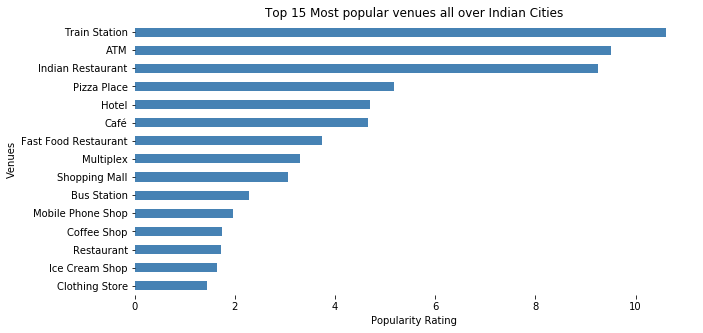

In [488]:
popular=venues_grouped.describe().loc['mean'].sort_values().tail(15)

ax=popular.plot(kind='barh', figsize=(10,5), color='steelblue')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda v,t: int(np.round(v*100))))

plt.title('Top 15 Most popular venues all over Indian Cities')
plt.ylabel('Venues')
plt.xlabel('Popularity Rating')
for spine in ax.spines:
    ax.spines[spine].set_visible(False)
plt.show()

In [489]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
top_venues_sorted = pd.DataFrame(columns=columns)
top_venues_sorted['City'] = venues_grouped['City']

for ind in np.arange(venues_grouped.shape[0]):
    top_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

top_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adoni,Indian Restaurant,Bus Station,Motorcycle Shop,Department Store,Train Station,Fish & Chips Shop,Farm,Farmers Market,Fast Food Restaurant,Field
1,Agra,Hotel,Indian Restaurant,Historic Site,Resort,Fast Food Restaurant,Café,Multicuisine Indian Restaurant,Market,Pizza Place,Coffee Shop
2,Ahmedabad,Indian Restaurant,Fast Food Restaurant,Café,Hotel,Pizza Place,Tea Room,Sandwich Place,Coffee Shop,Snack Place,Ice Cream Shop
3,Ahmednagar,Indian Restaurant,Italian Restaurant,Multiplex,Pizza Place,Coffee Shop,Food,Food & Drink Shop,Flea Market,Fish Market,Fabric Shop
4,Ajmer,Hotel,Indian Restaurant,Café,Lake,Vegetarian / Vegan Restaurant,Pizza Place,Design Studio,Monument / Landmark,Bakery,Coffee Shop


In [491]:
cities_grouped_clustering = venues_grouped.drop('City', 1)

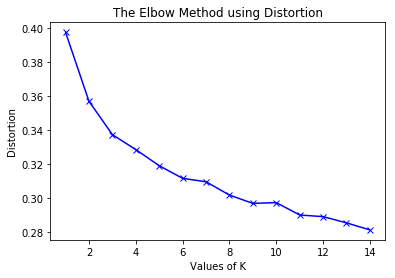

In [493]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,15)
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(cities_grouped_clustering) 
      
    distortions.append(sum(np.min(cdist(cities_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / cities_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(cities_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / cities_grouped_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

In [494]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cities_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([5, 1, 1, 5, 1, 4, 1, 1, 2, 2])

In [495]:
try:
    top_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
except:
    pass
cities_merged = dfct

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
cities_merged = cities_merged.join(top_venues_sorted.set_index('City'), on='City')

cities_merged.head()

,City,Population,State,Latitude,Longitude,Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ahmedabad,5570585,Gujarat,23.021624,72.579707,High,1,Indian Restaurant,Fast Food Restaurant,Café,Hotel,Pizza Place,Tea Room,Sandwich Place,Coffee Shop,Snack Place,Ice Cream Shop
1,Surat,4467797,Gujarat,21.186461,72.808128,High,1,Fast Food Restaurant,Indian Restaurant,Pizza Place,Chinese Restaurant,Restaurant,Café,Tea Room,Sandwich Place,Ice Cream Shop,Shopping Mall
2,Pune,3124458,Maharashtra,18.521428,73.854454,High,5,Indian Restaurant,Coffee Shop,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Dessert Shop,Snack Place,Sandwich Place,Café,Restaurant,Seafood Restaurant
3,Visakhapatnam,2982904,Andhra Pradesh,17.723128,83.301284,High,1,Indian Restaurant,Café,Hotel,Snack Place,Ice Cream Shop,Restaurant,Multiplex,Bakery,Food Court,Indie Movie Theater
4,Nagpur,2405665,Maharashtra,21.149813,79.082056,High,1,Indian Restaurant,Coffee Shop,Ice Cream Shop,Fast Food Restaurant,Pizza Place,Restaurant,Bakery,Snack Place,Sandwich Place,Café


In [496]:
from folium.features import DivIcon
# create map
map_clusters = folium.Map(location=[ll['latitude'], ll['longitude']], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []

for lat, lon, poi, cluster, Category in zip(cities_merged['Latitude'], cities_merged['Longitude'], cities_merged['City'], cities_merged['Cluster Labels'], cities_merged['Category']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    c='green'
    fc='#55aa77'
    if(Category=='High'):
        c='red'
        fc='#ff7755'
    elif(Category=='Medium'):
        c='yellow'
        fc='#aa9955'
    folium.CircleMarker([lat, lon], radius=7, popup=label, color=c, fill=True, fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

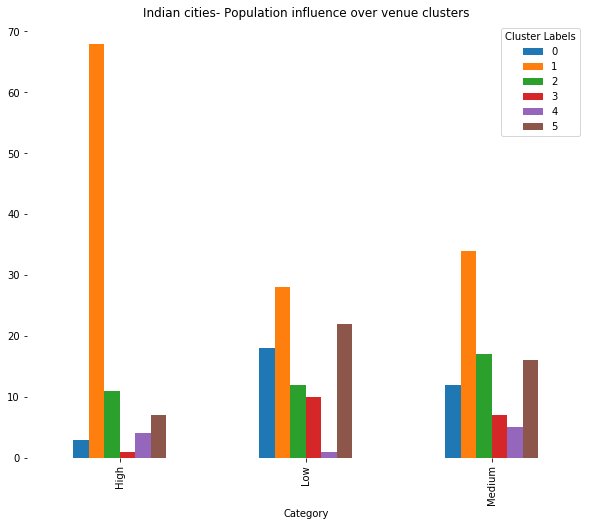

In [594]:
def plotCityGraph():
    dfg=cities_merged.groupby(['Category','Cluster Labels'])['Cluster Labels']
    ax=dfg.count().unstack('Cluster Labels').plot(
        kind='bar',
        figsize=(10,8))
    #ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,t: 'Cluster {}'.format(v)))
    plt.title('Indian cities- Population influence over venue clusters')
    #plt.xlabel('Venues')
    #plt.ylabel('Clusters')
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
    plt.show()

plotCityGraph()

In [356]:
cities_merged.loc[cities_merged['Cluster Labels'] == 1, cities_merged.columns[[0] + list(range(7, cities_merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ahmedabad,Indian Restaurant,Fast Food Restaurant,Café,Hotel,Pizza Place,Tea Room,Sandwich Place,Coffee Shop,Snack Place,Ice Cream Shop
1,Surat,Fast Food Restaurant,Indian Restaurant,Pizza Place,Chinese Restaurant,Restaurant,Café,Tea Room,Sandwich Place,Ice Cream Shop,Shopping Mall
2,Pune,Indian Restaurant,Coffee Shop,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Dessert Shop,Snack Place,Sandwich Place,Café,Restaurant,Seafood Restaurant
3,Visakhapatnam,Indian Restaurant,Café,Hotel,Snack Place,Ice Cream Shop,Restaurant,Multiplex,Bakery,Food Court,Indie Movie Theater
4,Nagpur,Indian Restaurant,Coffee Shop,Ice Cream Shop,Fast Food Restaurant,Pizza Place,Restaurant,Bakery,Snack Place,Sandwich Place,Café
6,Thane,Indian Restaurant,Fast Food Restaurant,Ice Cream Shop,Hotel,Coffee Shop,Chinese Restaurant,Seafood Restaurant,Donut Shop,Vegetarian / Vegan Restaurant,Clothing Store
7,Pimpri-Chinchwad,Indian Restaurant,Fast Food Restaurant,Pizza Place,Snack Place,Hotel,Café,Sandwich Place,Ice Cream Shop,Shopping Mall,Diner
8,Vadodara,Indian Restaurant,Fast Food Restaurant,Café,Multiplex,Pizza Place,Shopping Mall,Italian Restaurant,Sandwich Place,Snack Place,Asian Restaurant
9,Indore,Indian Restaurant,Fast Food Restaurant,Hotel,Coffee Shop,Pizza Place,Café,Ice Cream Shop,Sandwich Place,Snack Place,Tea Room
10,Ghaziabad,Indian Restaurant,Fast Food Restaurant,Pizza Place,Park,Shopping Mall,Bakery,Donut Shop,Arcade,Coffee Shop,Train Station


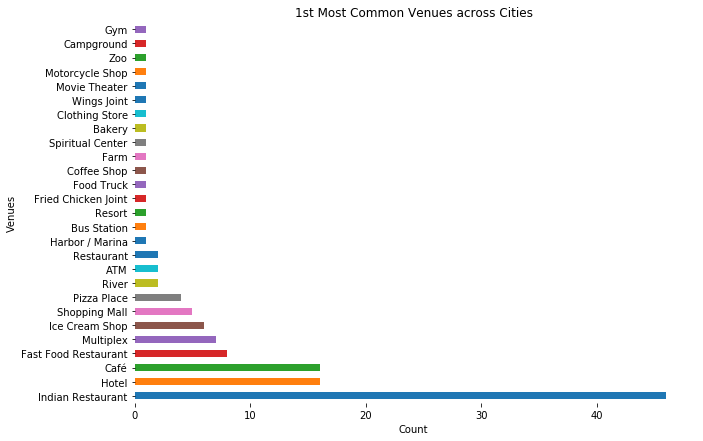

In [595]:
ax=cities_merged.loc[cities_merged['Cluster Labels'] == 1, cities_merged.columns[7]].value_counts().plot(kind='barh', figsize=(10,7))
plt.title('1st Most Common Venues across Cities')
plt.xlabel('Count')
plt.ylabel('Venues')
for spine in ax.spines:
    ax.spines[spine].set_visible(False)
plt.show()

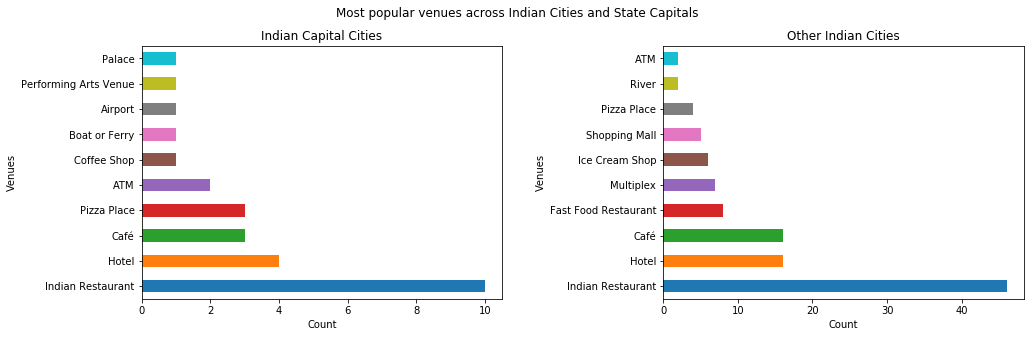

In [596]:
fig, ax = plt.subplots(1, 2)
fig.suptitle('Most popular venues across Indian Cities and State Capitals')


capitals_merged.loc[capitals_merged['Cluster Labels'] == 0, capitals_merged.columns[7]].value_counts().head(10).plot(kind='barh', 
                                                                                                        figsize=(15, 5),
                                                                                                        ax=ax[0])
ax[0].set_title('Indian Capital Cities')
ax[0].set_xlabel('Count')
ax[0].set_ylabel('Venues')

cities_merged.loc[cities_merged['Cluster Labels'] == 1, cities_merged.columns[7]].value_counts().head(10).plot(kind='barh', 
                                                                                                      figsize=(15, 5),
                                                                                                      ax=ax[1])
ax[1].set_title('Other Indian Cities')
ax[1].set_xlabel('Count')
ax[1].set_ylabel('Venues')

fig.tight_layout(pad=3.0)

plt.show()

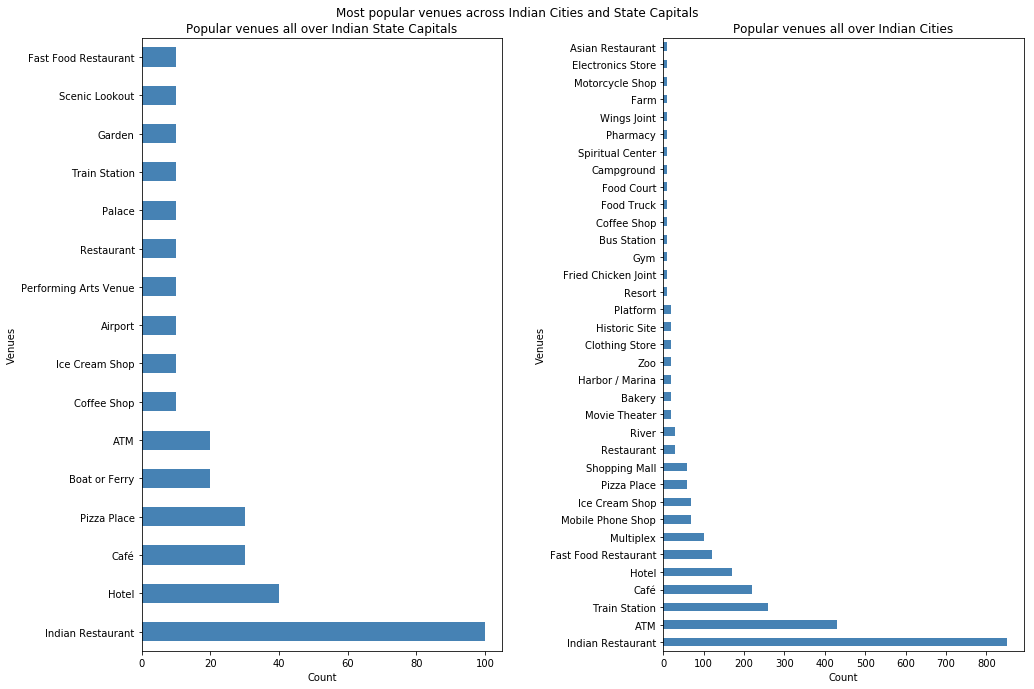

In [593]:
capital_venue_counts={}
for i in range(7, capitals_merged.shape[1]):
    res=capitals_merged.iloc[:,7].value_counts()
    for k in res.keys():
        if(k not in capital_venue_counts.keys()):
            capital_venue_counts[k]=0
        capital_venue_counts[k]+=res[k] 
        
city_venue_counts={}
for i in range(7, cities_merged.shape[1]):
    res=cities_merged.iloc[:,7].value_counts()
    for k in res.keys():
        if(k not in city_venue_counts.keys()):
            city_venue_counts[k]=0
        city_venue_counts[k]+=res[k] 
        
fig, ax = plt.subplots(1, 2)
fig.suptitle('Most popular venues across Indian Cities and State Capitals')

pd.DataFrame.from_dict(capital_venue_counts, orient='index').plot(kind='barh', figsize=(15, 10), color='steelblue', ax=ax[0])
ax[0].get_legend().remove()
ax[0].set_title('Popular venues all over Indian State Capitals')
ax[0].set_ylabel('Venues')
ax[0].set_xlabel('Count')

pd.DataFrame.from_dict(city_venue_counts, orient='index').plot(kind='barh', figsize=(15, 10), color='steelblue', ax=ax[1])
ax[1].get_legend().remove()
ax[1].set_title('Popular venues all over Indian Cities')
ax[1].set_ylabel('Venues')
ax[1].set_xlabel('Count')
fig.tight_layout(pad=3.0)

plt.show()